# 04 Fit light curves with DRW model

Using http://celerite.readthedocs.io/en/latest/python/kernel/

Since this package uses `tensorflow`, for python >3.7 a working solution is to first create a `tensorflow` custom conda environment, according to https://www.anaconda.com/blog/tensorflow-in-anaconda :

    conda create -n tensorflow_env tensorflow
    conda activate tensorflow_env

Then in that activated environment we can install `ipython`, `jupyter`, as well as `celerite` : 

    conda install ipython
    conda install -c conda-forge numpy pybind11 autograd
    conda install -c conda-forge celerite
    conda install jupyter

Then start the jupyter notebook in the directory containing this notebook (i.e. `04_fit_light_curves`) :

    cd 2023-clqso-ps1-ztf/code
    jupyter notebook &

Which will start the jupyter lab. Start this notebook with the standard `Python 3` kernel. 

**Note:** 
when one starts up the terminal , if that  `conda` environment is not turned on, i.e. 'active' (we can find out what `conda`  environment is running with 


    conda info --envs

that will list all available environments, with a `*` next to the currently activated one), we can run 
    
    conda activate tensorflow_env

to activate it. 

We also need to install in that environment two other required packages:

In [1]:
!pip install matplotlib

In [2]:
!pip install astropy

Now it should be possible to import packages below:

In [3]:
import numpy as np 
import celerite
import os 
import datetime
import matplotlib.pyplot as plt
from celerite import terms
from scipy.optimize import minimize
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

import functions as func

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Load the light curves. I show how to load one of them:

In [4]:
dr_path = os.path.join(os.getcwd(), 'ZTFDR17')
sdss_name='001626.54+003632.4'

# load the SDSS, PS1, ZTF data 
data_r_band = func.get_data_to_dict(dr_path,
                                    sdss_jid=sdss_name)
# day-average, perform sigma clipping 
avg_data_r = func.average_data(data_r_band, 
                               surveys_to_average=['ps1','ztf_synthetic'], 
                               Nsigma = 5)

Based on given 001626.54+003632.4, found data for J001626.54+003632.4_ZTF_r.csv
Using provided 001626.54+003632.4
Got ZTF_filename
Got SDSS_JID
Got SDSS_dbID
Got ztf_original
Got ztf_synthetic
Got sdss
Got ps1

ps1
Unique days:11 total number of observations: 19

ztf_synthetic
Unique days:168 total number of observations: 200


We can fit either parts of the light curve (eg. sdss-ps1), or the entire light curve (eg. sdss-ps1-ztf).

We create such parts of each light curve; since there are only two sub-parts here I call them `1` for `sdss-ps1` and `2` for `sdss-ps1-ztf` : 

In [5]:
avg_data_r.keys()

dict_keys(['ZTF_filename', 'SDSS_JID', 'SDSS_dbID', 'ztf_original', 'ztf_synthetic', 'sdss', 'ps1', 'Nsigma'])

Do not include `flagged` points that most likely correspond to flares, i.e. not in the DRW description; these are flagged for `ztf_synthetic` and `ps1`, i.e. the averaged surveys:

In [6]:
from astropy.table import Table
# SDSS has not been day-averaged, so it doesn't have any flagged points
y_sdss = avg_data_r['sdss']['mag'].data
yerr_sdss = avg_data_r['sdss']['magerr'].data
t_sdss = avg_data_r['sdss']['mjd'].data

# PS1 and ZTF contain points that departed from the mean beyond the chosen 5sigma limit:

lc = {}
for survey in ['ps1', 'ztf_synthetic']:
    lc[survey] = {}
    m1 = avg_data_r[survey]["large_error"]  # True if large error
    m2 = avg_data_r[survey]["large_departure"]  # True if large departure
    m12 = m1 | m2  # logical OR - True if either large error OR large departure
    mask = ~m12  # True only for not flagged points

    lc[survey]['y'] = avg_data_r[survey]['mag'].data[mask]
    lc[survey]['yerr'] = avg_data_r[survey]['magerr'].data[mask]
    lc[survey]['t'] = avg_data_r[survey]['mjd'].data[mask]


# first, the 'sdss-ps1' light curve:
y1 = np.append(y_sdss, lc['ps1']['y'])
yerr1 =  np.append(yerr_sdss, lc['ps1']['yerr'])
t1 = np.append(t_sdss, lc['ps1']['t'])

# create a version of that array sorting by time 
lc1 = Table([y1,yerr1,t1], names = ['y','yerr','t'])
lc1.sort('t')

# second, the `sdss-ps1-ztf` light curve:
y2 = y_sdss
yerr2 = yerr_sdss
t2 = t_sdss
for survey in ['ps1', 'ztf_synthetic']:
   y2 = np.append(y2, lc[survey]['y'])
   yerr2=  np.append(yerr2, lc[survey]['yerr'])
   t2 = np.append(t2, lc[survey]['t'])

lc2 = Table([y2,yerr2,t2], names = ['y','yerr','t'])
lc2.sort('t')

To illustrate that we've done it correctly, plot the two light curves below the original one:

ps1 single point color is #2ca02c
ztf_synthetic single point color is #9467bd
Saved as sdss_ztf_ps1_00162_combined_.png in /Users/chris/GradResearch/2023-clqso-ps1-ztf/code


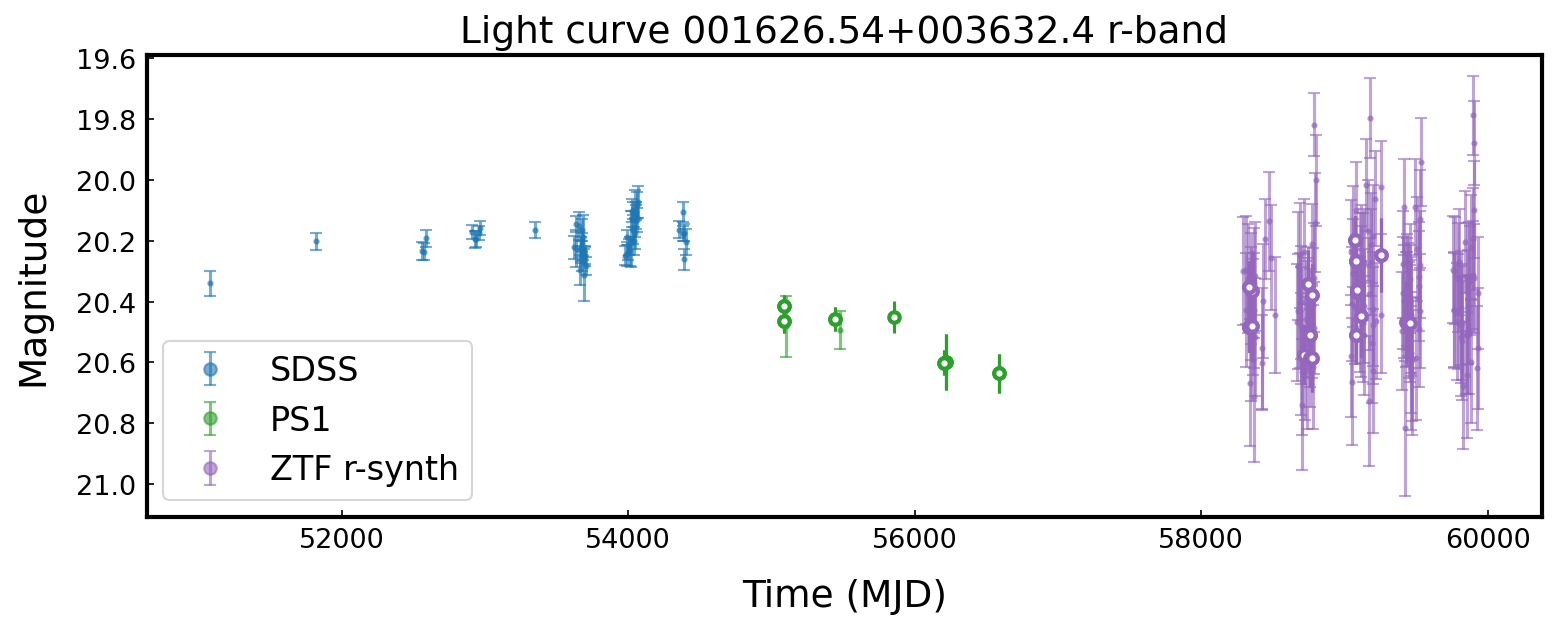

In [7]:
# plot the data 
import importlib as imp
imp.reload(func)
ax0 = func.plot_averaged_data(avg_data_r, plot_flagged=False, mjds=[], return_axis = True,
                             invert_yaxis=True)

Plot the SDSS-PS1:

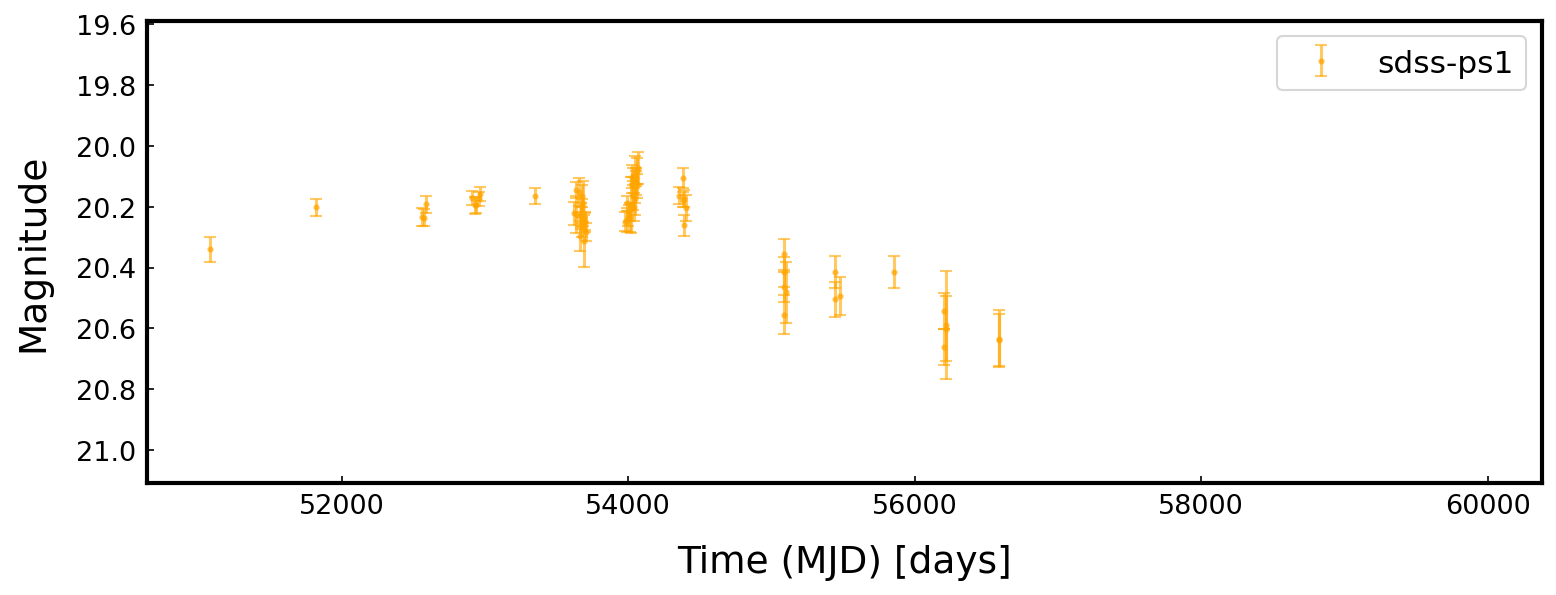

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4), dpi=150, facecolor="w")
ax1.errorbar(
       lc1['t'],lc1['y'],lc1['yerr'],
        fmt="o",
        markersize=2,
        alpha=0.6,
        capsize=3,
      label='sdss-ps1',
    color='orange'
    )
ax1.set_xlabel("Time (MJD) [days]", fontsize=18, labelpad=12)
ax1.set_ylabel("Magnitude", fontsize=18, labelpad=12)
ax1.set_xlim(ax0.get_xlim())
ax1.set_ylim(ax0.get_ylim())
ax1.tick_params(direction="in", pad=5, labelsize=13)
#ax1.set_title('SDSS-PS1')
ax1.legend()

Plot the SDSS-PS1-ZTF:

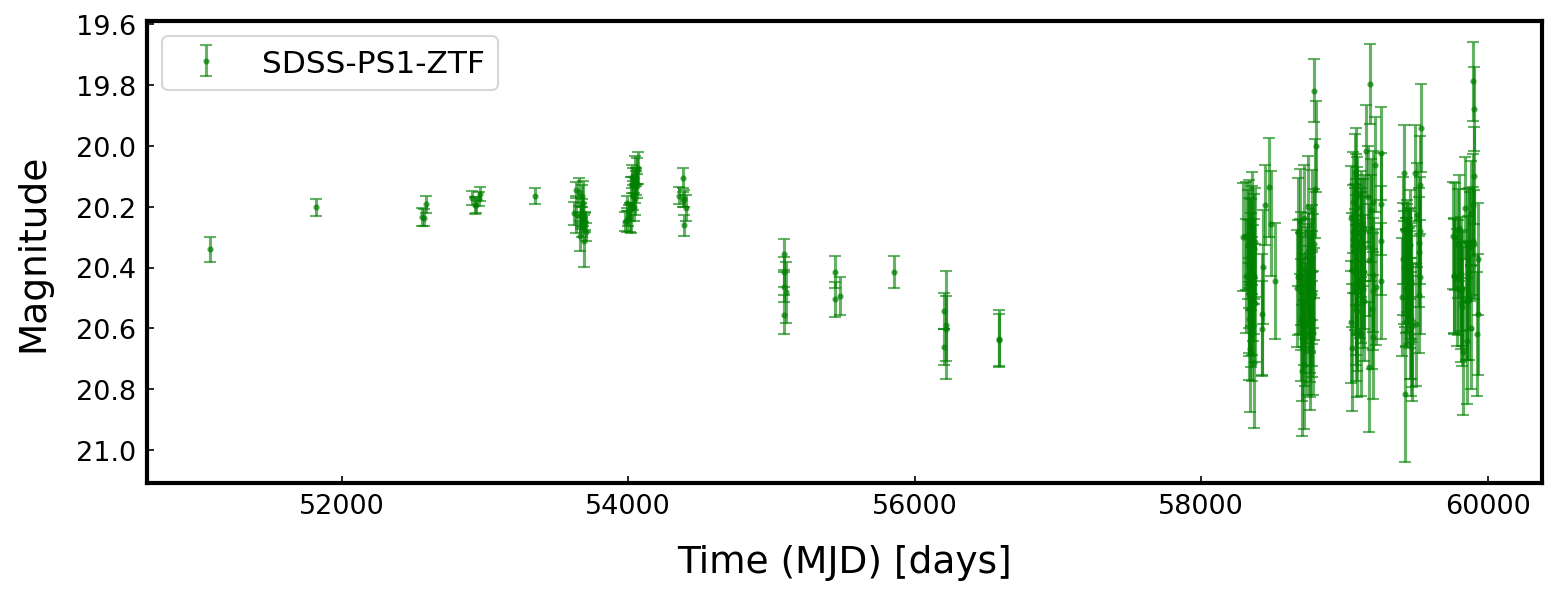

In [9]:
fig, ax2 = plt.subplots(1, 1, figsize=(12, 4), dpi=150, facecolor="w")
ax2.errorbar(
       lc2['t'],lc2['y'],lc2['yerr'],
        fmt="o",
        markersize=2,
        alpha=0.6,
        capsize=3,
      label='SDSS-PS1-ZTF',
    color='green'
    
    )
ax2.tick_params(direction="in", pad=5, labelsize=13)
ax2.set_xlabel("Time (MJD) [days]", fontsize=18, labelpad=12)
ax2.set_ylabel("Magnitude", fontsize=18, labelpad=12)
ax2.set_xlim(ax0.get_xlim())
ax2.set_ylim(ax0.get_ylim())
ax2.legend()

Define functions for fitting:

In [10]:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

In [11]:
def fit_with_celerite(t,y,yerr, sigma_in = 0.2, tau_in = 100, xlims=[], ylims=[],
                     plot_args = {'figsize':(12, 4), 'dpi':150, 'facecolor':"w"},
                     use_bounds=False, 
                     sigma_bounds = [0.01, 1.0], # in magnitudes
                     tau_bounds = [1,10000] # in days 
                      
                     ):

    # fitting procedure : 
    # initialize the Gaussian Process  RealTerm kernel ... 
    # it can be done once for all fittings ... 
    kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                            log_c = np.log(1/tau_in))


    
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)
    
    
    # optimization of the results 
    initial_params = gp.get_parameter_vector()

    bounds = gp.get_parameter_bounds()
    if use_bounds :
        print('fitting with custom bounds:')
        print(f'{sigma_bounds[0]} < sigma < {sigma_bounds[1]}')
        print(f'{tau_bounds[0]} < tau < {tau_bounds[1]}')
        # use custom bounds  : not much 
        # difference wrt built-in bounds 
        # ( i.e. no bounds at all , since 
        # this is - inf : + inf ) 
        loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
        logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
        bounds = [loga_bounds, logc_bounds]
    else:
        print('fitting with default bounds:')
        print(bounds)
        
    # do the scipy optimize to find the maximum likelihood estimator 
    # for hyperparameters.... 
    r = minimize(neg_log_like, initial_params, 
                 method="L-BFGS-B", args=(y, gp),
                bounds=bounds)
    gp.set_parameter_vector(r.x)
    res = gp.get_parameter_dict()
    sigma_fit = np.exp(res['kernel:log_a']/2)
    tau_fit = 1.0 / np.exp(res['kernel:log_c'])
    
    # quantities for plotting ... 
    x = np.linspace(min(t),max(t) , 5000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)
    
    
    color = "#ff7f0e"
    fig,ax=plt.subplots(1,1, **plot_args )
    ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    ax.plot(x, pred_mean, color=color)
    ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                     edgecolor="none")
   
    ax.tick_params(direction="in", pad=5, labelsize=13)
    ax.set_xlabel("Time (MJD) [days]", fontsize=18, labelpad=12)
    ax.set_ylabel("Magnitude", fontsize=18, labelpad=12)
    ax.set_title(' '+\
                    r'$\tau_{fit}=$'+str(tau_fit)[:5]+' days, '+\
                    r'$\sigma_{fit}=$'+str(sigma_fit)[:5]+\
                ' mag', multialignment='left')
    if len(xlims)>0:
        ax.set_xlim(xlims)
    if len(ylims)>0:
        ax.set_ylim(ylims)
    

fitting with default bounds:
[(None, None), (None, None)]


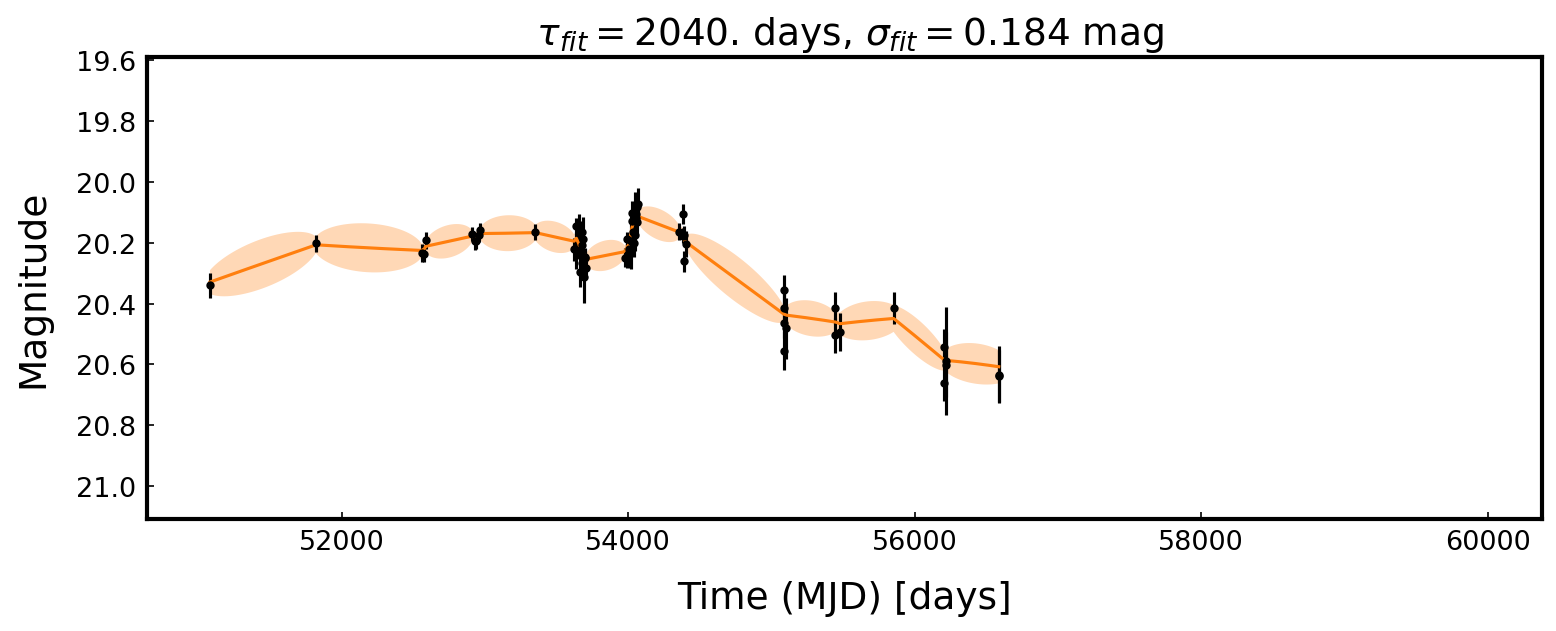

In [12]:
fit_with_celerite(t=lc1['t'], y=lc1['y'], yerr = lc1['yerr'], xlims=ax0.get_xlim(), ylims=ax0.get_ylim())

fitting with custom bounds:
0.01 < sigma < 1.0
1 < tau < 10000


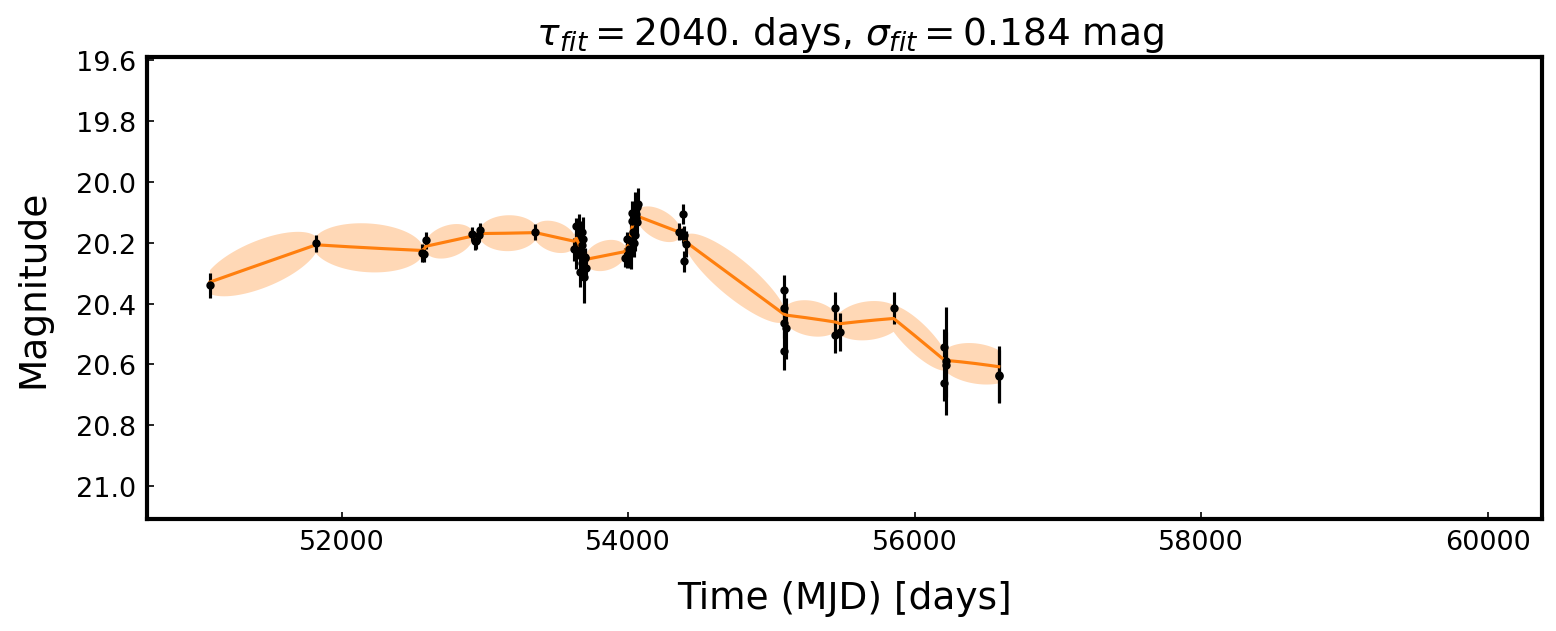

In [13]:
fit_with_celerite(t=lc1['t'], y=lc1['y'], yerr = lc1['yerr'], xlims=ax0.get_xlim(), ylims=ax0.get_ylim(),
                 use_bounds=True)

Fit the longest version of this light curve:

fitting with custom bounds:
0.01 < sigma < 1.0
1 < tau < 10000


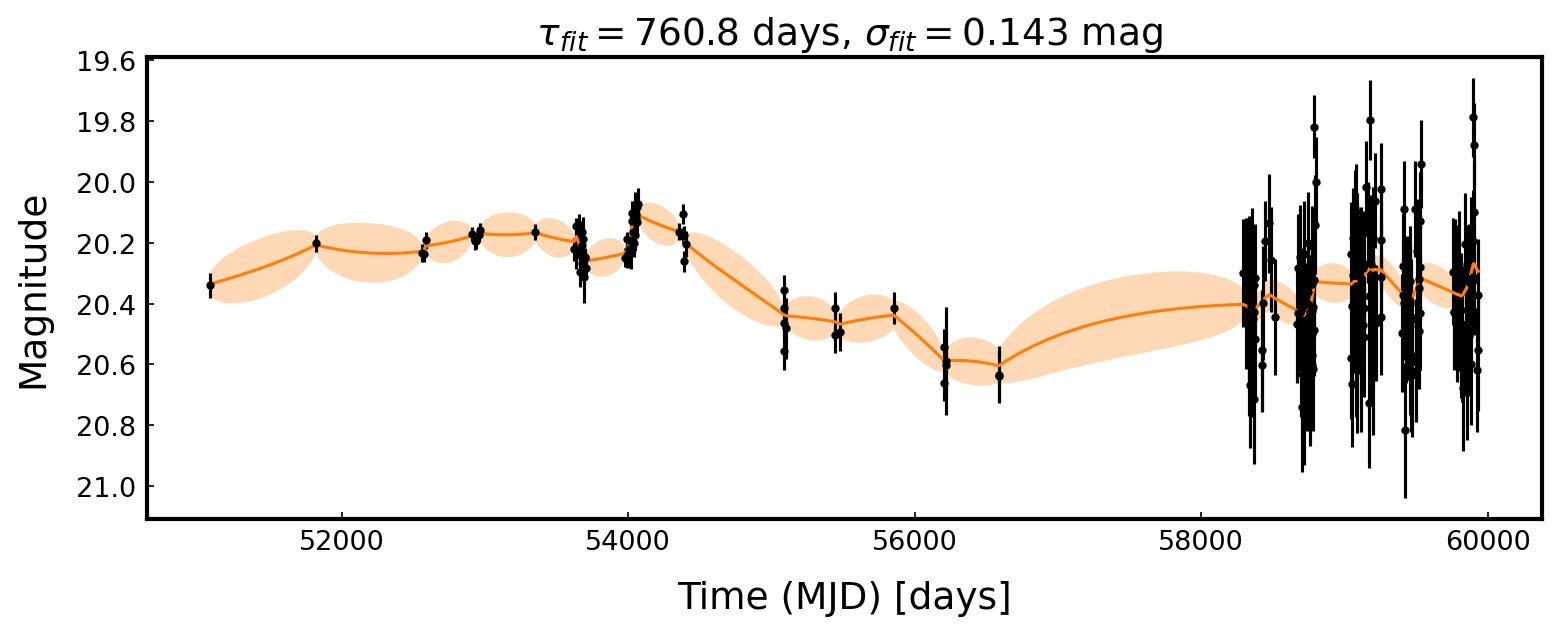

In [14]:
fit_with_celerite(t=lc2['t'], y=lc2['y'], yerr = lc2['yerr'], xlims=ax0.get_xlim(), ylims=ax0.get_ylim(),
                 use_bounds=True)